# Covid-19 tracker

Updated on 2020-07-17

Written in Julia 1.4

## Code

In [1]:
using CSV
using DataFrames
using TimeSeries
using Dates
using Statistics
using JSON
import HTTP
using Plots, Plots.Measures

const _DATE_STR = r"^\d{1,2}\/\d{1,2}\/\d{2}$"
# John Hopkins database
const url_header = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

_WB_ISO2_CODES = Dict(
    "Korea, South" => "KR",
    "US" => "US"
)


list_countries(df) = sort(collect(Set(df["global_confirmed"][!, "Country/Region"])))


function download_data()
    df = (
      global_confirmed = DataFrame!(CSV.File(HTTP.get(url_header * "time_series_covid19_confirmed_global.csv").body)),
      global_deaths = DataFrame!(CSV.File(HTTP.get(url_header * "time_series_covid19_deaths_global.csv").body)),
      us_deaths = DataFrame!(CSV.File(HTTP.get(url_header * "time_series_covid19_deaths_US.csv").body)),
      us_confirmed = DataFrame!(CSV.File(HTTP.get(url_header * "time_series_covid19_confirmed_US.csv").body))
    )
    return df
end


function get_iso2(str)
    # getting ISO2 code from the worldbank
    url = "http://api.worldbank.org/v2/countries/all?per_page=25000&format=json"
    request = HTTP.get(url)
    out = JSON.parse(String(request.body))
    matches = [(x["iso2Code"], x["name"]) for x in out[2] if occursin(str, x["name"])]
    if length(matches) == 1
        return matches[1][1]
    elseif isempty(matches)
        @error "No country names matches " * str
    else
        @warn string(length(matches)) * " countries match " * str
        @warn matches
    end
end


function get_pop(code_iso2; year=2019)
    # getting country's population from the worldbank
    url = "http://api.worldbank.org/v2/country/" * code_iso2 * "/indicator/SP.POP.TOTL?date=" * string(year) * "&format=json"
    request = HTTP.get(url)
    out = JSON.parse(String(request.body))
    return out[2][1]["value"]
end


function to_TimeArray(df; init_date=Date(2020, 3, 1))
    return stack(df, names(df), variable_name=:date, variable_eltype=String) |>  ## tranpose the dataset -- make columns (dates) into rows
        x -> select!(x, :date => ByRow(x -> Date(x, "mm/dd/yy") + Dates.Year(2000)) => :date, :value) |>  ## convert and fix the dates
        x -> TimeArray(x, timestamp=:date) |> ## convert to time array
        x -> x[init_date:Day(1):Date(2030,1,1)] ## select after March 2020
end


function get_counties(f, series, df)
    return filter(f, df[series]) |> ## select county
    x -> x[!, _DATE_STR] |> ## only column dates
    x -> mapcols(sum ∘ skipmissing, x) |> ## aggregate across columns (dates) -- should not be necessary by county
    x -> to_TimeArray(x)
end

get_counties_pop(f,  df) = filter(f, df[:us_deaths])[!, :Population] |> sum ∘ skipmissing

get_county(county, state, series, df) =  get_counties(x-> (x["Province_State"] === state) & (x["Admin2"] === county), series, df)

get_state(state, series, df) = get_counties(x-> (x["Province_State"] === state), series, df)

function get_county_pc(county, state, series, df)
    f = x -> (x["Province_State"] === state) & (x["Admin2"] === county)
    return get_counties(f, series, df) ./ get_counties_pop(f, df) .* 1_000_000.0
end


function get_state_pc(state, series, df)
    f = x -> (x["Province_State"] === state)
    return get_counties(f, series, df) ./ get_counties_pop(f, df) .* 1_000_000.0
end


function get_country(country, series, df)
    return filtered = filter(x-> x["Country/Region"] === country, df[series]) |> ## select country
        x -> x[!, _DATE_STR] |> ## only columns names that are dates
        x -> mapcols(sum ∘ skipmissing, x) |> ## aggregate across all columns (dates)
        x -> to_TimeArray(x)
end


function get_country_pc(country, series, df)
    iso2 = country in keys(_WB_ISO2_CODES) ? _WB_ISO2_CODES[country] : get_iso2(country)
    pop = get_pop(iso2)
    ta = get_country(country, series, df)  ./ pop .* 1_000_000.0
    return ta
end


function plot_helper(ta)
    fig = plot(ta, ribbon=(0.0 .* values(ta), -values(ta)), linewidth=2, legend=false)
    ta_ma = lead(moving(mean, ta, 7), 3) ## centered moving average
    plot!(fig, ta_ma, color=:black, linewidth=2, legend=false)
    ticks = Date(2020, 03, 1):Month(1):Date(now())
    labels = monthabbr.(ticks)
    labels[1] = labels[1] * "\n2020"
    xticks!(fig, Dates.value.(ticks), labels)
    return fig
end


my_diff(ts) = max.(diff(ts), 0) ## take first differences and drop negative obs


function make_daily_plot(ts_deaths, ts_confirmed, title)
    fig1 = plot_helper(my_diff(ts_deaths))
    title!(fig1, title * ", deaths", titlelocation=:left, top_margin=[5mm 0mm])
    ylabel!(fig1, "daily per million")

    fig2 = plot_helper(my_diff(ts_confirmed))
    title!(fig2, title * ", confirmed cases", titlelocation=:left, top_margin=[5mm 0mm])
    ylabel!(fig2, "daily per million")

    return plot(fig1, fig2, size=(900, 300), layout=2)
end


function plot_country_pc_daily(country, df)
    return make_daily_plot(
        get_country_pc(country, :global_deaths, df),
        get_country_pc(country, :global_confirmed, df),
        country
    )
end


function plot_county_pc_daily(county, state, df)
    return make_daily_plot(
        get_county_pc(county, state, :us_deaths, df),
        get_county_pc(county, state, :us_confirmed, df),
        county * ", " * state
    )
end


function plot_state_pc_daily(state, df)
    return make_daily_plot(
        get_state_pc(state, :us_deaths, df),
        get_state_pc(state, :us_confirmed, df),
        state
    )
end

plot_state_pc_daily (generic function with 1 method)

## Getting the get_data

In [2]:
df = download_data();

## US County/State plots

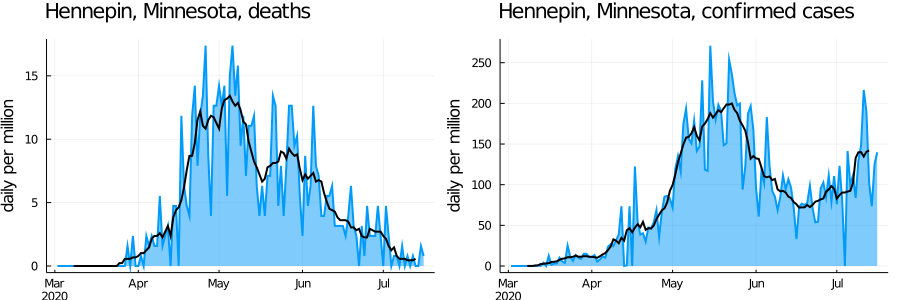

In [3]:
plot_county_pc_daily("Hennepin", "Minnesota", df)

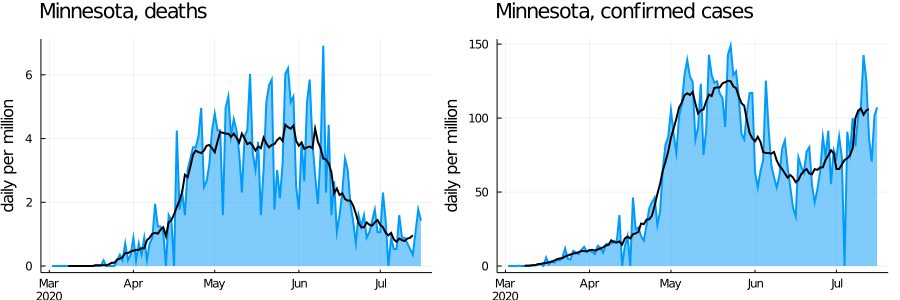

In [4]:
plot_state_pc_daily("Minnesota", df)

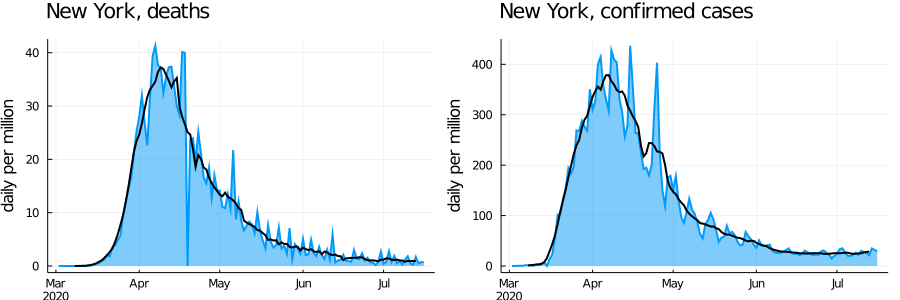

In [5]:
plot_state_pc_daily("New York", df)

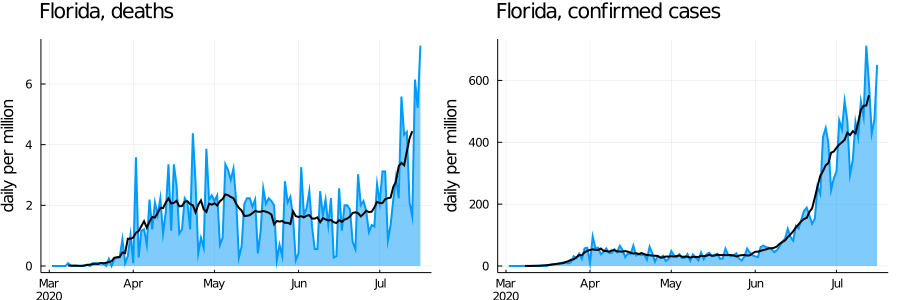

In [6]:
plot_state_pc_daily("Florida", df)

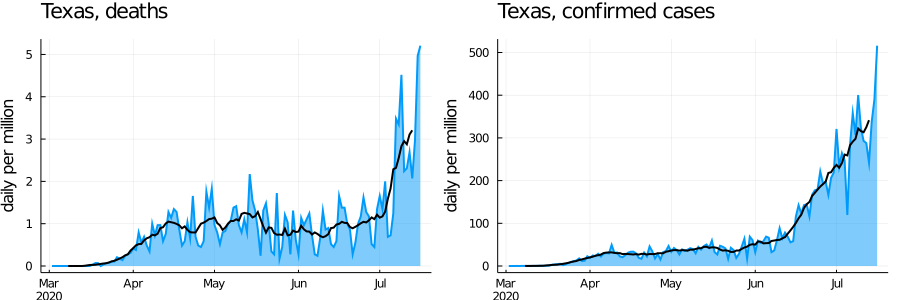

In [7]:
plot_state_pc_daily("Texas", df)

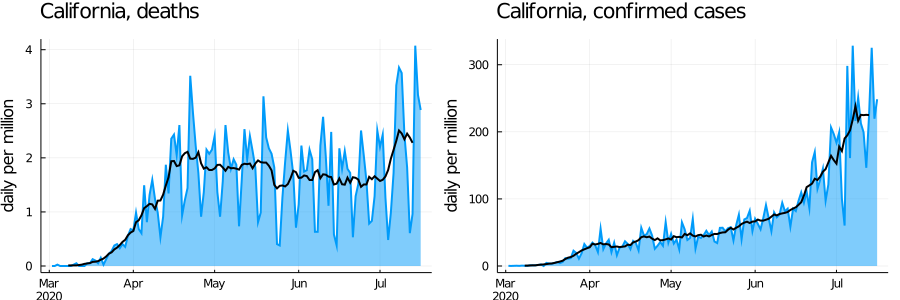

In [8]:
plot_state_pc_daily("California", df)

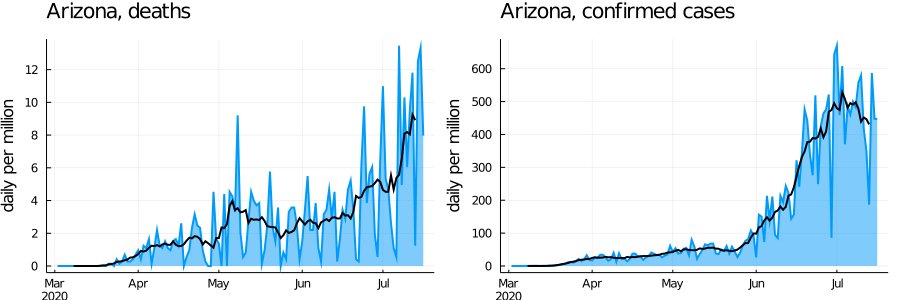

In [9]:
plot_state_pc_daily("Arizona", df)

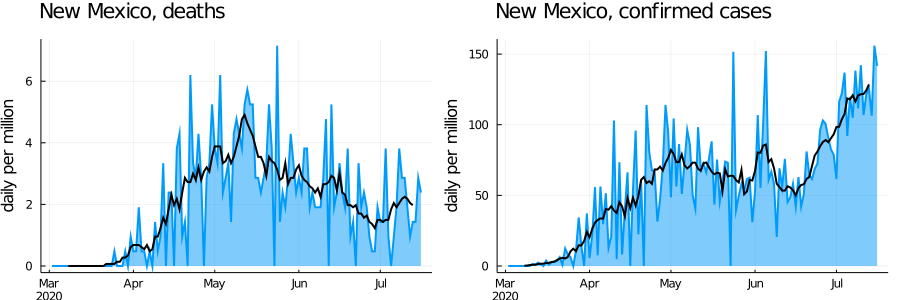

In [10]:
plot_state_pc_daily("New Mexico", df)

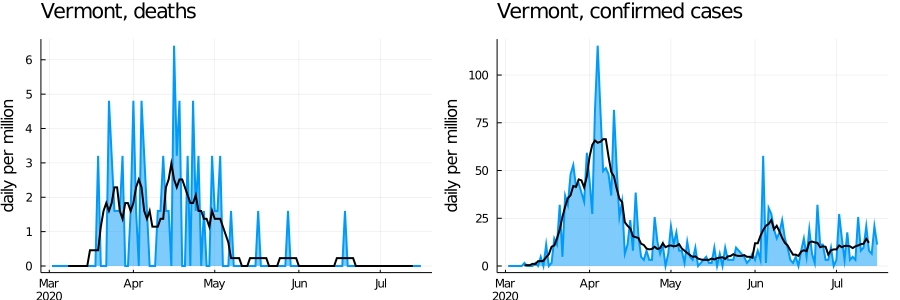

In [11]:
plot_state_pc_daily("Vermont", df)

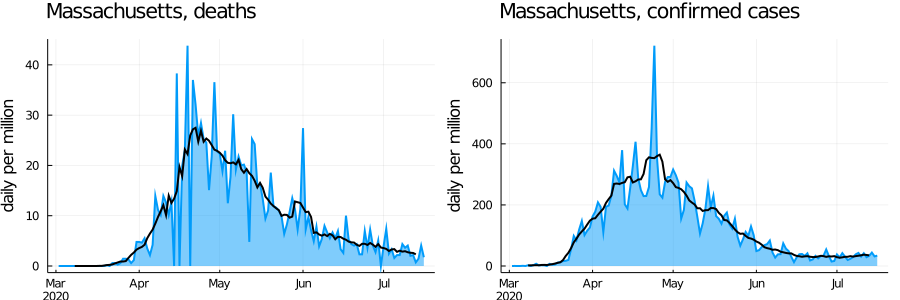

In [12]:
plot_state_pc_daily("Massachusetts", df)

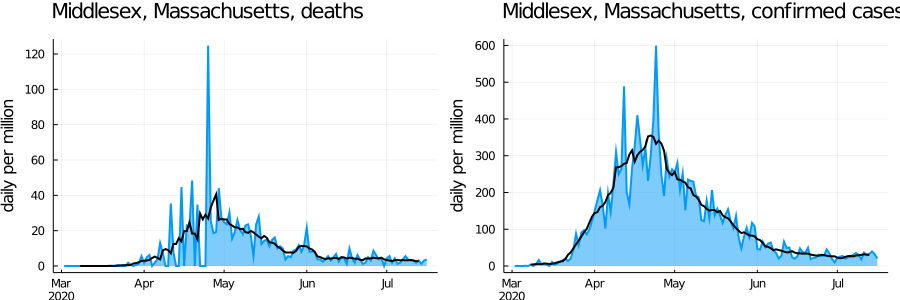

In [13]:
plot_county_pc_daily("Middlesex", "Massachusetts", df)

## Country plots

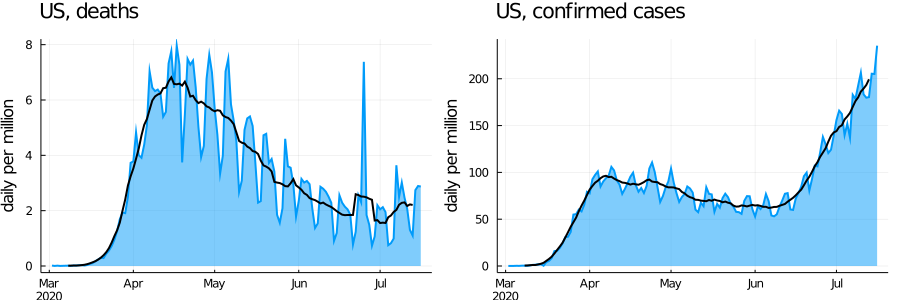

In [14]:
plot_country_pc_daily("US", df)

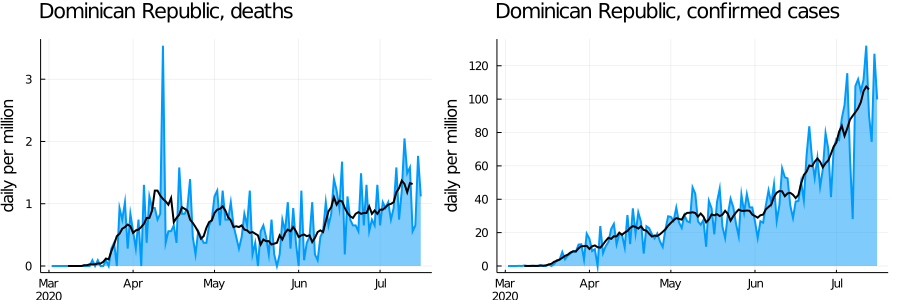

In [15]:
plot_country_pc_daily("Dominican Republic", df)

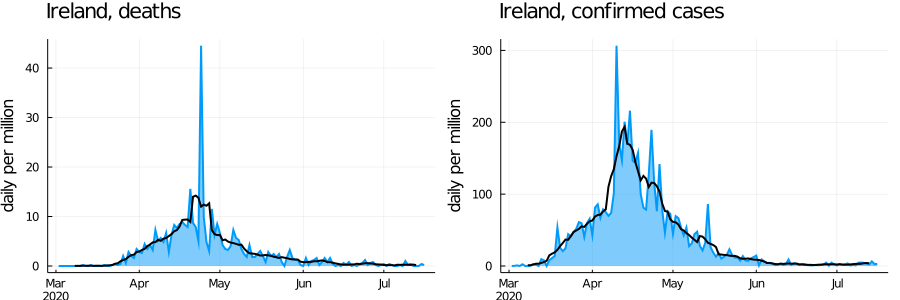

In [16]:
plot_country_pc_daily("Ireland", df)

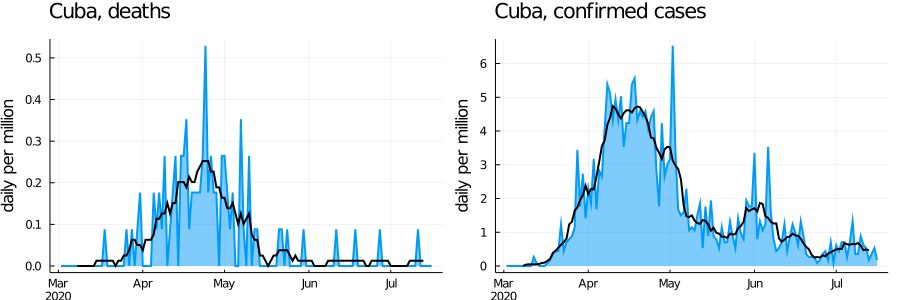

In [17]:
plot_country_pc_daily("Cuba", df)

### Europe

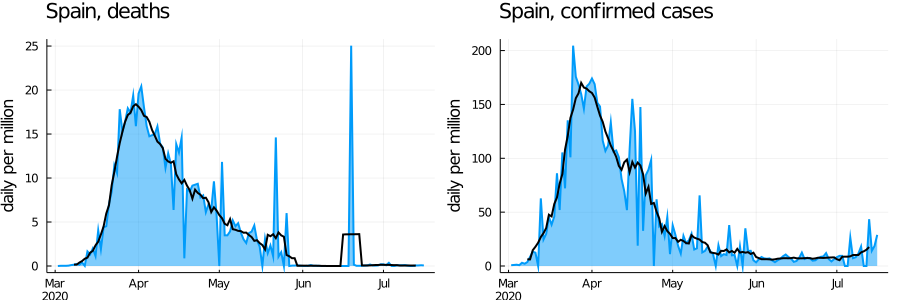

In [18]:
plot_country_pc_daily("Spain", df)

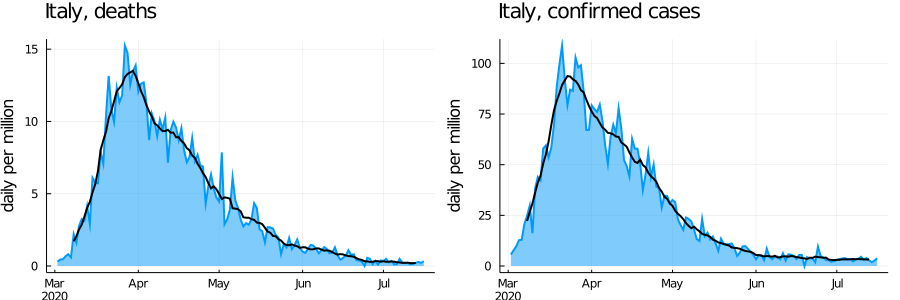

In [19]:
plot_country_pc_daily("Italy", df)

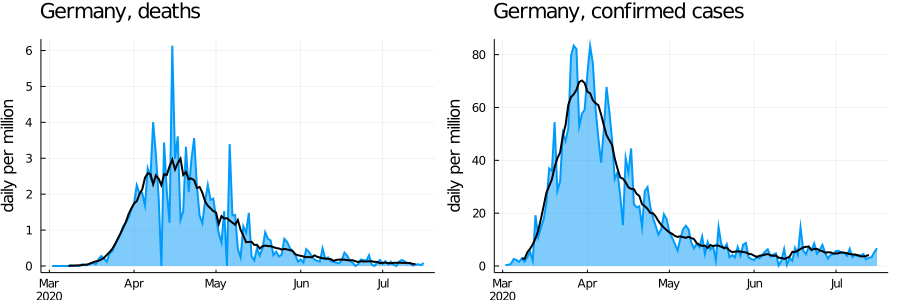

In [20]:
plot_country_pc_daily("Germany", df)

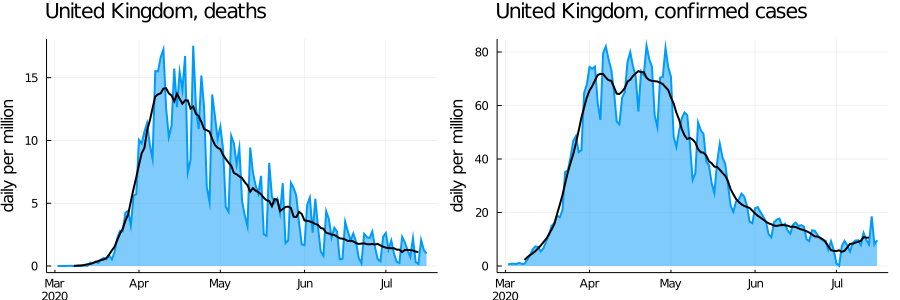

In [21]:
plot_country_pc_daily("United Kingdom", df)

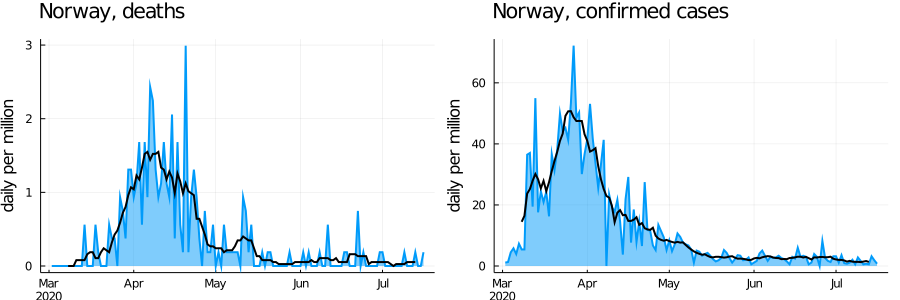

In [22]:
plot_country_pc_daily("Norway", df)

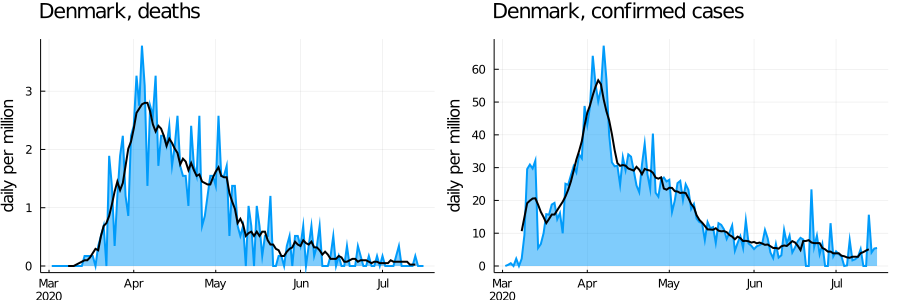

In [23]:
plot_country_pc_daily("Denmark", df)

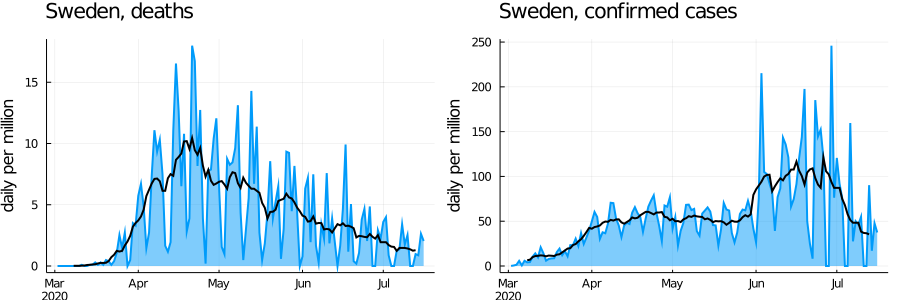

In [24]:
plot_country_pc_daily("Sweden", df)

### Latin America

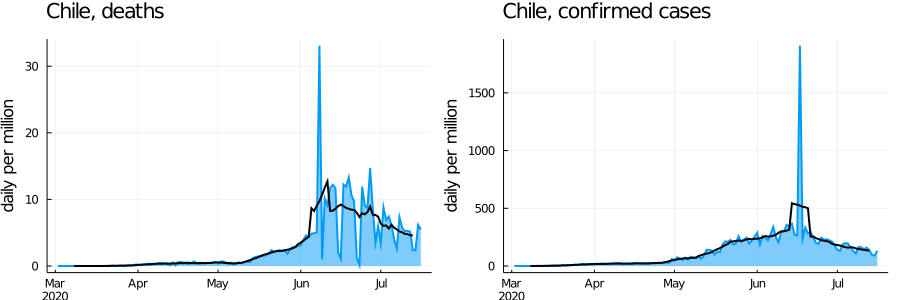

In [25]:
plot_country_pc_daily("Chile", df)

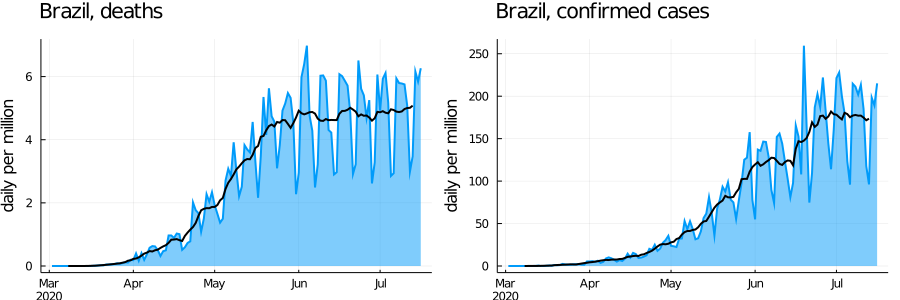

In [26]:
plot_country_pc_daily("Brazil", df)

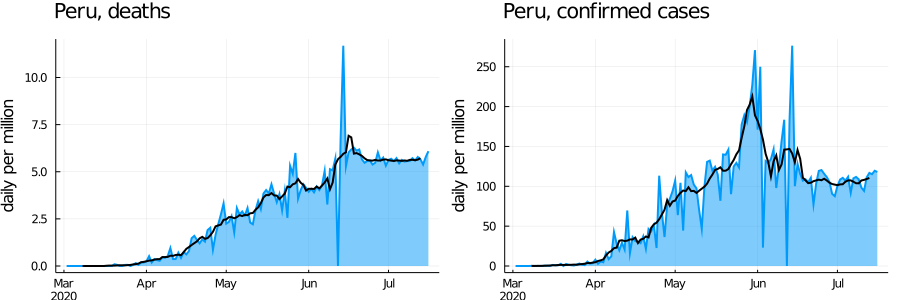

In [27]:
plot_country_pc_daily("Peru", df)

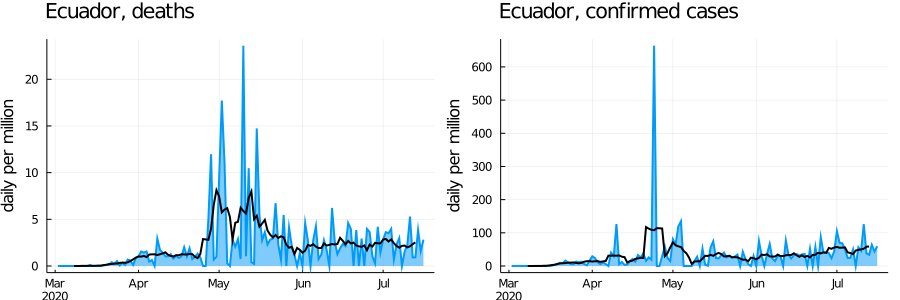

In [28]:
plot_country_pc_daily("Ecuador", df)

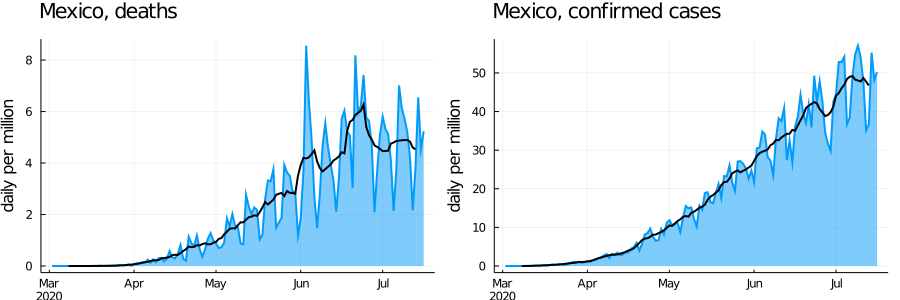

In [29]:
plot_country_pc_daily("Mexico", df)

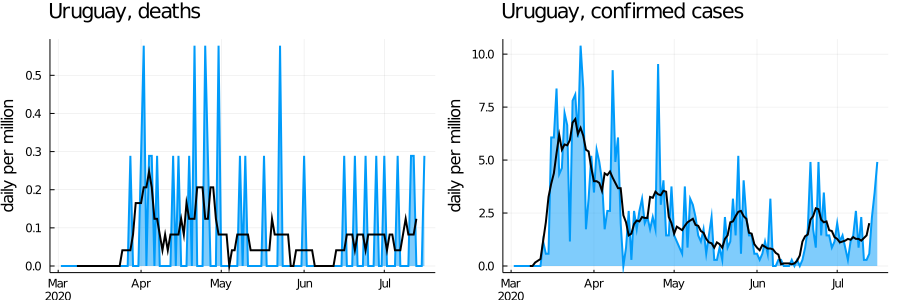

In [30]:
plot_country_pc_daily("Uruguay", df)

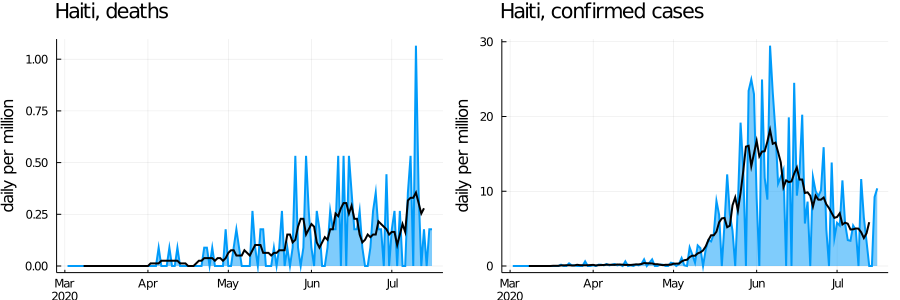

In [31]:
plot_country_pc_daily("Haiti", df)

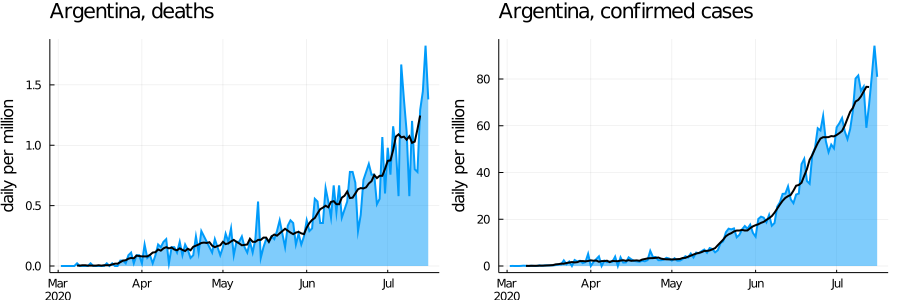

In [32]:
plot_country_pc_daily("Argentina", df)

### Asia

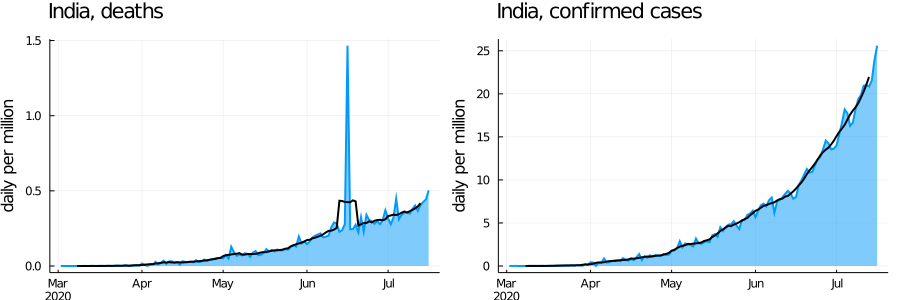

In [33]:
plot_country_pc_daily("India", df)

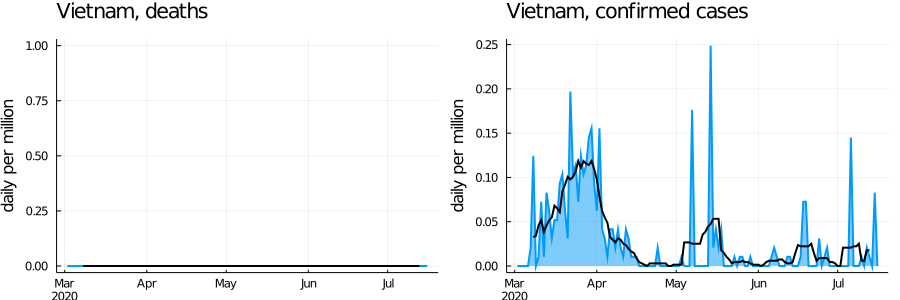

In [34]:
plot_country_pc_daily("Vietnam", df)

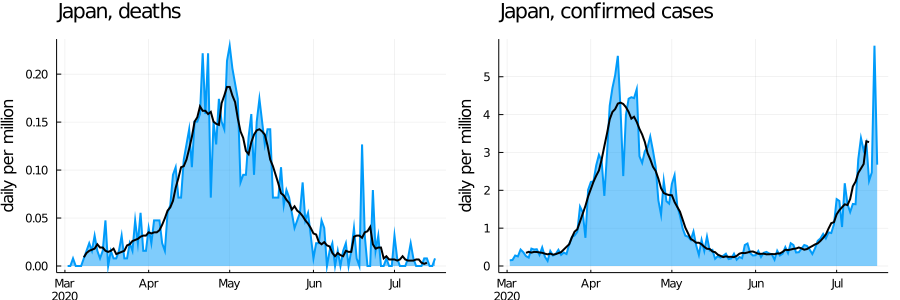

In [35]:
plot_country_pc_daily("Japan", df)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*